In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import json

import torchvision
import torch

from pathlib import Path
from PIL import Image
from pprint import pprint
from tqdm import tqdm

from torch import nn, optim
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler

# custom imports
from fairface_classification import data, resnet_model, utils, metrics, train

# launch tensorboard writer
writer = SummaryWriter('../runs/fairface/')

utils.set_random_seed(42)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The following is the model architecture I am going to train on FairFace Dataset

Almost the whole model and its architecture - ResNet50 pretrained on ImageNet dataset. The last layer is modified and adapted to current FairFace dataset. There are just 3 classes that should predicted at the same time, so the last layer of the model will have three "heads".

In [37]:
show_pic = False

if show_pic:
    Image.open('../model_architecture.png')

In [38]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
resnet = resnet50(weights='IMAGENET1K_V1')
train_label.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


### Initialize Dataset and Dataloader

In [39]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 0,
         '10-19': 2,
         '20-29': 3,
         '3-9': 1,
         '30-39': 4,
         '40-49': 5,
         '50-59': 6,
         '60-69': 7,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [40]:
train_samples = json.load(open('../train_test_val.json'))['train']
label_train_test = pd.read_csv('../data/fairface_label_train.csv')

class_weights = utils.calc_tasks_weight({'age' : age_dict, 'gender' : gender_dict, 'race' : race_dict})
train_labels = utils.calc_category_weights(train_samples, label_train_test, {'age_dict' : age_dict, 'race_dict' : race_dict, 'gender_dict' : gender_dict})

       age: 1.50
      race: 1.17
    gender: 0.33


In [41]:
def group_class_weight(labels):
    """
    It is another way of calculation of image weight for oversampling technique.

    Args:
        labels: pd.DataFrame - dataframe with filenames and its labels.
    Returns:
        labels: pd.DataFrame - dataframe with calculated weights for every file and its labels.
    """

    labels['group'] = labels.apply(lambda x: f'{x["age"]}{x["gender"]}{x["race"]}', axis=1)
    group_vc = labels['group'].value_counts()
    group_counts = group_vc.to_frame().reset_index()
    labels = labels.merge(group_counts, on='group', how='left') 
    labels['group_weight'] = 1 / labels['count']
    return labels

train_labels = group_class_weight(train_labels)
train_labels.head()

,file,age,gender,race,age_weight,gender_weight,race_weight,total_weight,group,count,group_weight
0,train/1.jpg,6,0,3,0.000202,0.000027,0.000102,0.000330,603,272,0.003676
1,train/2.jpg,4,1,2,0.000065,0.000031,0.000102,0.000197,412,931,0.001074
2,train/4.jpg,3,1,2,0.000049,0.000031,0.000102,0.000181,312,1347,0.000742
3,train/5.jpg,3,1,2,0.000049,0.000031,0.000102,0.000181,312,1347,0.000742
4,train/7.jpg,5,0,6,0.000116,0.000027,0.000136,0.000279,506,961,0.001041


In [42]:
train_labels.drop(['age_weight', 'gender_weight', 'race_weight', 'total_weight'], axis=1)

,file,age,gender,race,group,count,group_weight
0,train/1.jpg,6,0,3,603,272,0.003676
1,train/2.jpg,4,1,2,412,931,0.001074
2,train/4.jpg,3,1,2,312,1347,0.000742
3,train/5.jpg,3,1,2,312,1347,0.000742
4,train/7.jpg,5,0,6,506,961,0.001041
...,...,...,...,...,...,...,...
69390,train/86738.jpg,2,0,2,202,510,0.001961
69391,train/86741.jpg,2,0,2,202,510,0.001961
69392,train/86742.jpg,8,1,2,812,93,0.010753
69393,train/86743.jpg,2,1,4,214,663,0.001508


In [43]:
root_dir = Path('..')
images_dir = 'data/'

# Set the batch size for 64 samples
batch_size = 2

sampler = WeightedRandomSampler(weights=train_labels['group_weight'], num_samples=len(train_labels), replacement=True)

# Create a FairFaceDataset object for the training data.
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.RandomHorizontalFlip(p=0.5),
                                                                      transforms.RandomPerspective(p=0.5),
                                                                      transforms.RandomGrayscale(p=0.2),
                                                                      transforms.RandomAdjustSharpness(2, p=0.5),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                           std=[0.229, 0.224, 0.225])
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_train.train()
# Create a DataLoader object for the training data.
train_loader = DataLoader(fairface_train, batch_size=batch_size, num_workers=5, sampler=sampler)

# Create a FairFaceDataset object for the test data.
fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_test.train()
# Create a DataLoader object for the test data.
test_loader = DataLoader(fairface_test, batch_size=batch_size, shuffle=True, num_workers=5)

# Create a FairFaceDataset object for the validation data.
fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_val.train()
# Create a DataLoader object for the validation data.
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


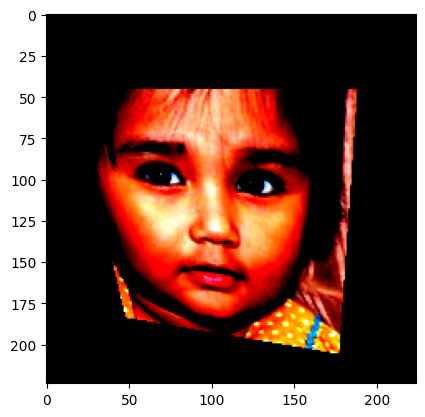

In [47]:
def display_torch_img(dataset, index):
    """Displays a single image from the given dataset at the given index.

    Args:
        dataset: A PyTorch dataset object or the array of tensors.
        index: The index of the image to display.

    Returns:
        None.
    """

    # Check if the dataset is a FairFaceDataset object.
    if type(dataset) == data.FairFaceDataset:

        # Get the image from the dataset.
        img = dataset[index]['image']

        # If the image is a 4D tensor, squeeze it to a 3D tensor.
        if len(dataset[index]['image'].shape) == 4:
            img = torch.squeeze(img)

    # Otherwise, the dataset is assumed to be an array of tensors.
    else:

        # Get the image from the dataset.
        img = dataset[index]

    # Permute the image axes so that the channel axis is the last axis.
    img = img.permute(1, 2, 0)

    # Display the image using Matplotlib.
    plt.imshow(img)
    plt.show()

display_torch_img(fairface_train, 35)

### Sample data

In [48]:
img_grid = torchvision.utils.make_grid(fairface_train[13]['image'])
writer.add_image('fairface_image1', img_grid)

img_grid = torchvision.utils.make_grid(fairface_train[26]['image'])
writer.add_image('fairface_image2', img_grid)

for i in range(5):
    img_grid = torchvision.utils.make_grid(fairface_train[43 + i]['image'])
    writer.add_image(f'fairface_image{i + 3}', img_grid)

### First try of training a neural network

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
model = resnet_model.FairFaceResNet(resnet).to(device)

# For race and age classes
bce = nn.BCELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


### Train model

In [50]:
# map ages
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}


class_dicts = {'age' : age_dict, 
               'race' : race_dict, 
               'gender': gender_dict}
# train the model
best_model = train.train_model(model, criterion, 
                               optimizer, scheduler_lr=scheduler, 
                               device=device, loaders=[train_loader, test_loader],
                               tensor_writer=writer, mappings=mappings, class_dicts=class_dicts,
                               class_weights=class_weights, n_epochs=35)

  0%|          | 0/34698 [00:00<?, ?it/s]

  0%|          | 54/34698 [00:12<1:03:46,  9.05it/s]

In [ ]:
best_dir = Path('../models/checkpoint/checkpoint.pt')
model, optimizer, epoch = utils.load_ckp(best_dir, model, optimizer)
model = model.to(device)


100%|██████████| 22/22 [00:05<00:00,  3.95it/s]


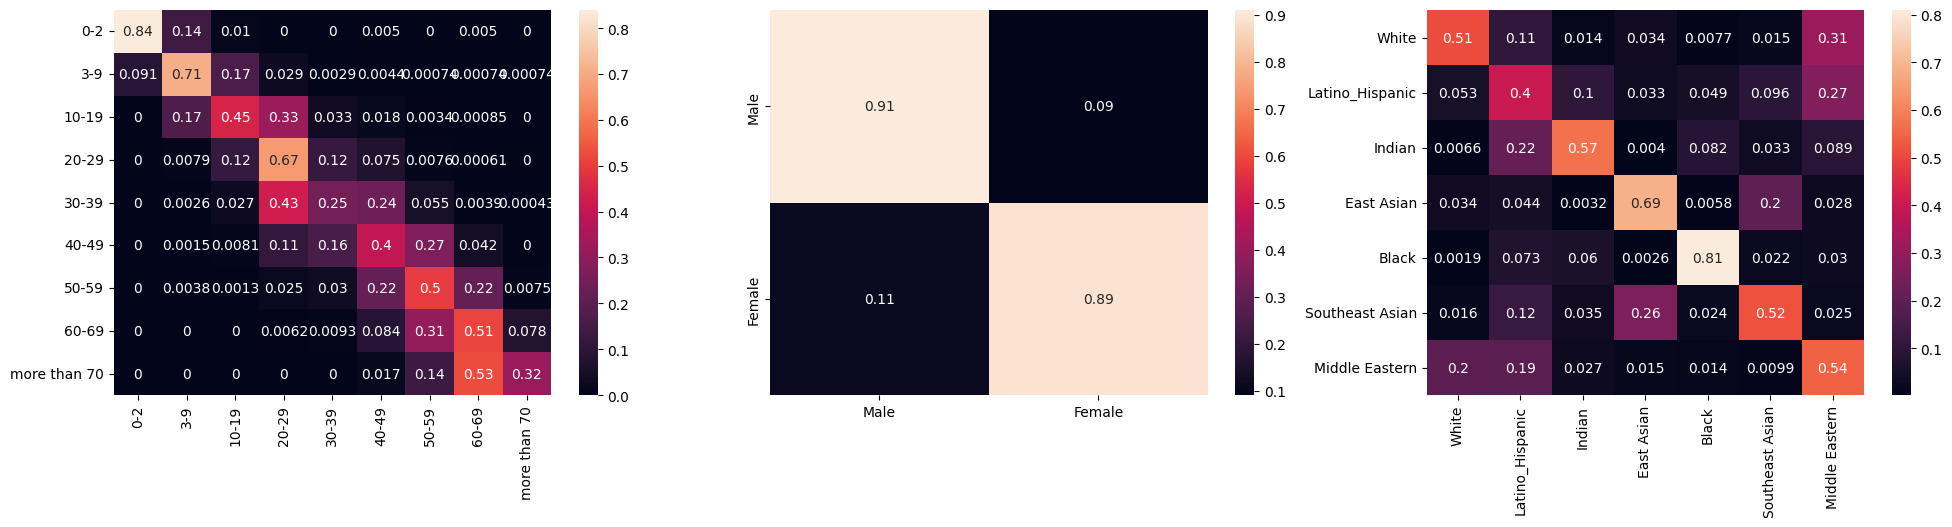

In [ ]:
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}

ages, genders, races = metrics.build_confusion_matrix(model, val_loader, mappings, device=device)

In [ ]:
metrics.calc_measures(model, val_loader, device)

100%|██████████| 22/22 [00:06<00:00,  3.46it/s]


,accuracy,precision,recall,f1
age,0.508855,0.493169,0.515885,0.492138
gender,0.899671,0.899534,0.899070,0.899282
race,0.573946,0.593161,0.576566,0.577226


In [ ]:
def get_mismatched_classes(model, loader, true_cat, pred_cat, dictionary, output_class, device):
    """Gets the mismatched images for the given model, loader, true category, predicted category, dictionary, output class, and device.

    Args:
        model: The model to evaluate.
        loader: The loader to use to load the data.
        true_cat: The true category.
        pred_cat: The predicted category.
        dictionary: A dictionary mapping category names to indices.
        output_class: The output class.
        device: The device to use.

    Returns:
        A list of mismatched images.
    """
    # Initialize a list to store the mismatched images.
    mismatched_img = []
    # Set the model to evaluation mode.
    model.eval()
    # Iterate over the loader.
    with torch.no_grad():   
          
        for batch in tqdm(loader):
            # Move the images and labels to the device.
            image = batch['image'].to(device)
            age = batch[output_class].to(device)
            # Make a prediction.
            output = model(image)

            # Get the predicted class.
            _, predicted = torch.max(torch.softmax(output[f'{output_class}_pred'].data, dim=1), 1)
            # Iterate over the true and predicted classes.
            for true, pred, img in zip(age, predicted, image):
                # If the true and predicted categories are not the same, add the image to the list of mismatched images.
                if dictionary[true_cat] == int(true) and dictionary[pred_cat] == int(pred):
                    mismatched_img.append(img)
                    
    # Return the list of mismatched images.
    return mismatched_img

true_cat = 'Latino_Hispanic'
pred_cat = 'Middle Eastern'
mism_imgs = get_mismatched_classes(model, val_loader, true_cat, pred_cat, race_dict, 'race', device)
mism_imgs = [i.cpu() for i in mism_imgs]

100%|██████████| 22/22 [00:05<00:00,  3.84it/s]


In [ ]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

class Unnormalize(nn.Module):
    def __init__(self, mean, std):
        super(Unnormalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return self.unnormalize(x)

    def unnormalize(self, x):
        # Assuming x is a PyTorch tensor
        return x * self.std[None, :, None, None] + self.mean[None, :, None, None]

def show(imgs, true_cat, pred_cat):
    if not os.path.exists('../mismatched'):
        os.mkdir('../mismatched')
        
    img_batch = []
    cur_batch = 1
    if not isinstance(imgs, list):
        imgs = [imgs]
    for i, img in enumerate(tqdm(imgs)):
        img = np.array(img).transpose(1, 2, 0)
        img_batch.append(img)
        
        if (i + 1) % 20 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.title(f'True category = {true_cat}; Mismatched one = {pred_cat}')
            columns = 4
            rows = 5
            for i in range(1, columns*rows + 1):
                img = img_batch[i - 1]
                ax = fig.add_subplot(rows, columns, i)
                ax.set_axis_off()
                plt.imshow(img)
            fig.set_tight_layout(tight=True)
            fig.savefig(f'../mismatched/mismatched_age_number_{cur_batch}.png')
            plt.close()

            cur_batch += 1
            img_batch = []

# Example Usage:
mean = [0.485, 0.456, 0.406]  # Replace with your actual mean values
std = [0.229, 0.224, 0.225]   # Replace with your actual standard deviation values

# Create an instance of Unnormalize
unnormalize = Unnormalize(mean=mean, std=std)
show([unnormalize(i).squeeze(0) for i in mism_imgs], true_cat, pred_cat)

100%|██████████| 435/435 [00:22<00:00, 19.62it/s]
